In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import tqdm.notebook as tqdm

import seaborn as sns
import numpy as np
import duckdb
import pandas as pd
import geopandas as gpd
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime



from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay, confusion_matrix,
                            classification_report, auc, roc_curve)

### Folder Structure

```
geoai_flood_prediction/
│── data/
│   ├── OIL_MILL_AXIS/
│   │   ├── prediction_points/
│   │   │   ├── predictive_points.shp
│   │   │   ├── predictive_points.dbf
│   │   │   ├── predictive_points.shx
│   │   ├── sampling_points/
│   │   │   ├── sampling_points.shp
│   │   │   ├── sampling_points.dbf
│   │   │   ├── sampling_points.shx
│   │   ├── output/
│   │   ├── OIL_MILL_AXIS.shp
│   │   ├── OIL_MILL_AXIS.dbf
│   │   ├── OIL_MILL_AXIS.shx
│── script.py


```

### Set Workspace

In [2]:
# Define working directory and data directory
WORKING_DIR = 'C:/Users/Admin/Desktop/geoai_flood_prediction'
DATA_FOLDER = 'data/PH_METRO/TRAIN'
DATA_DIR = os.path.join(WORKING_DIR,DATA_FOLDER)

# Define folder names
PREDICTIVE_POINT_FOLDER = "prediction_points"
SAMPLING_POINT_FOLDER = "sampling_points"
OUTPUT_FOLDER = 'output'
INPUT_FOLDER = 'input'

# Additional datasets
FLOOD_PREDICTIVE_POINT = "predictive_points.shp"
FLOOD_SAMPLING_POINT = "sampling_points.shp"
FLOOD_PREDICTIVE_PAQ_POINT = "predictive_points.parquet"

# Construct full paths for directories
PREDICTIVE_POINT_DIR = os.path.join(DATA_DIR, PREDICTIVE_POINT_FOLDER)
SAMPLING_POINT_DIR = os.path.join(DATA_DIR, SAMPLING_POINT_FOLDER)
OUTPUT_DIR = os.path.join(DATA_DIR, OUTPUT_FOLDER)
INPUT_DIR = os.path.join(DATA_DIR, INPUT_FOLDER)

# Paths to additional datasets
FLOOD_PREDICTIVE_PATH = os.path.join(PREDICTIVE_POINT_DIR, FLOOD_PREDICTIVE_POINT)
FLOOD_SAMPLING_PATH = os.path.join(SAMPLING_POINT_DIR, FLOOD_SAMPLING_POINT)
FLOOD_PREDICTIVE_PAQ_PATH = os.path.join(PREDICTIVE_POINT_DIR, FLOOD_PREDICTIVE_PAQ_POINT)


# List of directories to verify
required_dirs = [
    WORKING_DIR, DATA_DIR, PREDICTIVE_POINT_DIR, SAMPLING_POINT_DIR, OUTPUT_DIR
]

# Check if all required directories exist
for directory in required_dirs:
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")

# Ensure additional dataset files exist
dataset_files = [FLOOD_PREDICTIVE_PATH, FLOOD_SAMPLING_PATH]
for dataset_path in dataset_files:
    if not os.path.exists(dataset_path):
        print(f"Warning: {dataset_path} does not exist!")


###  Load Datasets

In [3]:
data_gdf  = gpd.read_file(FLOOD_SAMPLING_PATH)
data_gdf.head()

,Label,aspect,blue,curvature,dsm,dtm,ele_diff,flow_accum,flow_dir,green,hand_model,lulc,openwater,red,slope,tri,twi,geometry
0,1,159.3720,116.3590,-0.032288,28.3717,28.3941,-0.006515,29.0,1,131.8440,-9999.00000,3.0,7259.80,145.6560,1.11013,5.32924,2.66667,POINT (293720.953 523509.173)
1,1,49.8945,106.5160,-0.010454,28.5557,28.5176,0.060306,3.0,128,113.5620,-9999.00000,5.0,7222.21,122.2660,1.87839,5.34084,-9999.00000,POINT (293697.591 523540.879)
2,1,186.0910,95.2656,-0.027441,28.6044,28.6263,-0.005522,5.0,4,113.0310,2.41231,3.0,7193.63,111.2660,4.06543,5.35648,1.32895,POINT (293680.07 523566.327)
3,1,131.8230,83.2500,-0.049291,27.9616,28.0197,-0.026798,1.0,4,100.0780,-9999.00000,3.0,7522.21,115.8750,1.41894,5.29359,-1.87707,POINT (294202.796 523739.456)
4,1,331.1140,79.0781,0.000562,27.9525,28.2184,-0.353550,17.0,32,78.5625,1.95729,1.0,7459.19,80.2188,1.66298,5.31207,-9999.00000,POINT (294175.679 523813.297)


In [4]:
data_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Label       1150 non-null   int64   
 1   aspect      1150 non-null   float64 
 2   blue        1150 non-null   float64 
 3   curvature   1150 non-null   float64 
 4   dsm         1150 non-null   float64 
 5   dtm         1150 non-null   float64 
 6   ele_diff    1150 non-null   float64 
 7   flow_accum  1150 non-null   float64 
 8   flow_dir    1150 non-null   int64   
 9   green       1150 non-null   float64 
 10  hand_model  1150 non-null   float64 
 11  lulc        1150 non-null   float64 
 12  openwater   1150 non-null   float64 
 13  red         1150 non-null   float64 
 14  slope       1150 non-null   float64 
 15  tri         1150 non-null   float64 
 16  twi         1150 non-null   float64 
 17  geometry    1150 non-null   geometry
dtypes: float64(15), geometry(1), int64(2)
me

In [5]:
data_gdf.describe()

,Label,aspect,blue,curvature,dsm,dtm,ele_diff,flow_accum,flow_dir,green,hand_model,lulc,openwater,red,slope,tri,twi
count,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000
mean,0.518261,169.852878,-38.086806,-139.123852,-116.260628,-117.455353,-137.948068,712.308696,27.990435,-21.755266,-448.235352,-144.952174,1355.706423,-17.478285,-3.299943,5.511519,-5598.289274
std,0.499884,317.764140,1221.228116,1171.692987,1211.114712,1210.964175,1171.835436,26727.722998,39.528299,1223.164149,2079.352395,1207.572852,2466.530336,1223.822199,295.112319,0.678799,4966.831553
min,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,1.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,3.542200,-9999.000000
25%,0.000000,89.390950,83.378900,-0.019189,26.893275,25.972425,-0.034011,1.000000,2.000000,100.238250,1.429807,2.000000,257.300000,99.445325,1.328845,5.116030,-9999.000000
50%,1.000000,176.132500,108.383000,-0.001781,31.260050,30.062350,0.009579,6.000000,8.000000,126.469000,3.028340,3.000000,647.149000,130.727000,2.611260,5.501060,-9999.000000
75%,1.000000,268.274000,136.222500,0.003681,36.262500,34.488575,1.648918,24.000000,32.000000,150.855250,5.356152,4.000000,2108.402500,159.375000,5.894613,5.879893,2.048353
max,1.000000,359.759000,240.781000,0.577274,58.886700,50.768400,19.102700,571380.000000,128.000000,241.203000,25.888500,5.000000,8375.420000,241.578000,62.005600,7.139090,13.149400


In [6]:
# Replace all NaN values with 0
data_gdf = data_gdf.fillna(0)

# Replace all -9999 values with 0
data_gdf = data_gdf.replace(-9999, 0)

# Check for any remaining NaN values
data_gdf.isna().sum()

Label         0
aspect        0
blue          0
curvature     0
dsm           0
dtm           0
ele_diff      0
flow_accum    0
flow_dir      0
green         0
hand_model    0
lulc          0
openwater     0
red           0
slope         0
tri           0
twi           0
geometry      0
dtype: int64

In [7]:
data_gdf.columns

Index(['Label', 'aspect', 'blue', 'curvature', 'dsm', 'dtm', 'ele_diff',
       'flow_accum', 'flow_dir', 'green', 'hand_model', 'lulc', 'openwater',
       'red', 'slope', 'tri', 'twi', 'geometry'],
      dtype='object')

In [8]:
df = data_gdf.drop('geometry',axis=1)
df.head().T

,0,1,2,3,4
Label,1.000000,1.000000,1.000000,1.000000,1.000000
aspect,159.372000,49.894500,186.091000,131.823000,331.114000
blue,116.359000,106.516000,95.265600,83.250000,79.078100
curvature,-0.032288,-0.010454,-0.027441,-0.049291,0.000562
dsm,28.371700,28.555700,28.604400,27.961600,27.952500
dtm,28.394100,28.517600,28.626300,28.019700,28.218400
ele_diff,-0.006515,0.060306,-0.005522,-0.026798,-0.353550
flow_accum,29.000000,3.000000,5.000000,1.000000,17.000000
flow_dir,1.000000,128.000000,4.000000,4.000000,32.000000
green,131.844000,113.562000,113.031000,100.078000,78.562500


## Building Deep Neaural Network

In [9]:
#Define the dependent variable that needs to be predicted (labels)
feature = "Label"
Y = df[feature].values

In [10]:
# Define the independent variables. Let's also drop geometry and label
X = df.drop(labels = [feature], axis=1)
# Convert X from dataframe to array to train the neural netowrk
X_arr= X.to_numpy()

### Split Train Test

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, 
                                test_size=0.2,shuffle=True, random_state=42)

## Evaluate Model

In [12]:
# X variable count
X_shape = X_train.shape[1]

model_name = "DNN"

# model network layers
model =Sequential([
    Dense(9, activation='relu', input_shape=(X_shape,)),
    Dropout(0.1),
    Dense(64, activation= 'relu'),
    Dropout(0.4),
    Dense(64, activation= 'relu'),
    Dropout(0.4),
    Dense(64, activation= 'relu'),
    Dense(1,activation= 'sigmoid'),
])

# save model
checkpoint = ModelCheckpoint(
    "DNN.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  
)

# Early stopping to stop the network when there is no improvement based on the validation loss
early = EarlyStopping(monitor='val_loss', 
                      min_delta=0,
                      patience=1000, 
                      verbose=1, 
                      mode='auto')

# The training and validation losses for each epoch 
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name))

# model compilation
model.compile(optimizer = 
              'adam',
              loss = 
              'binary_crossentropy',
              metrics = ['accuracy'])

# model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 153       
                                                                 
 dropout (Dropout)           (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [13]:
# Train the deep neural network (DNN) using early stopping and model checkpointing
history = model.fit(X_train, y_train,
                    epochs=1000, verbose=2,
                    batch_size=64,
                    validation_split=0.20,
                    callbacks=[checkpoint, early, tensorboard]
                   )

Epoch 1/1000

Epoch 1: val_loss improved from inf to 5.54912, saving model to DNN.h5
12/12 - 5s - loss: 43.4474 - accuracy: 0.4864 - val_loss: 5.5491 - val_accuracy: 0.4946 - 5s/epoch - 386ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 5.54912 to 3.92349, saving model to DNN.h5
12/12 - 0s - loss: 44.1984 - accuracy: 0.5014 - val_loss: 3.9235 - val_accuracy: 0.4783 - 218ms/epoch - 18ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 3.92349 to 1.46503, saving model to DNN.h5
12/12 - 0s - loss: 44.2529 - accuracy: 0.5163 - val_loss: 1.4650 - val_accuracy: 0.4402 - 288ms/epoch - 24ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 1.46503
12/12 - 0s - loss: 17.9472 - accuracy: 0.5190 - val_loss: 5.8835 - val_accuracy: 0.5652 - 155ms/epoch - 13ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 1.46503
12/12 - 0s - loss: 16.5324 - accuracy: 0.5082 - val_loss: 8.8965 - val_accuracy: 0.5652 - 135ms/epoch - 11ms/step
Epoch 6/1000

Epoch 6: val_loss did not improve

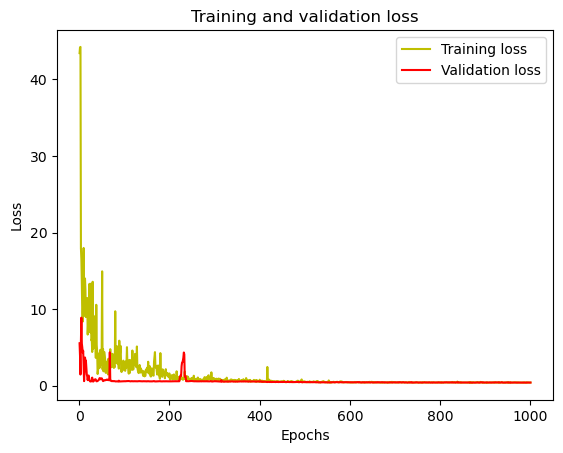

In [14]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

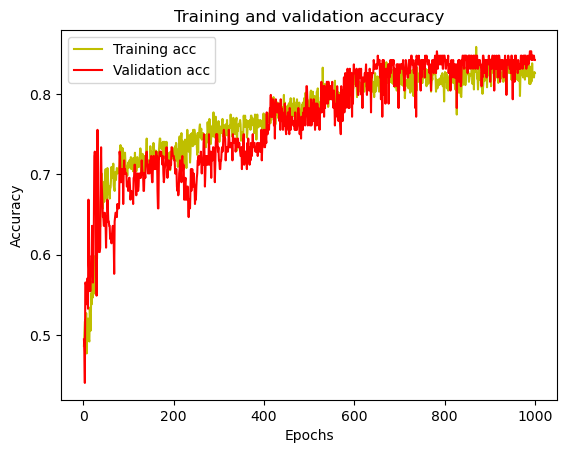

In [15]:
#plot the training and validation accuracy at each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model Accuracy

In [16]:
# Evaluate the model on validation data and calculate accuracy
_, acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 83.04%


8/8 [==============================] - 0s 2ms/step


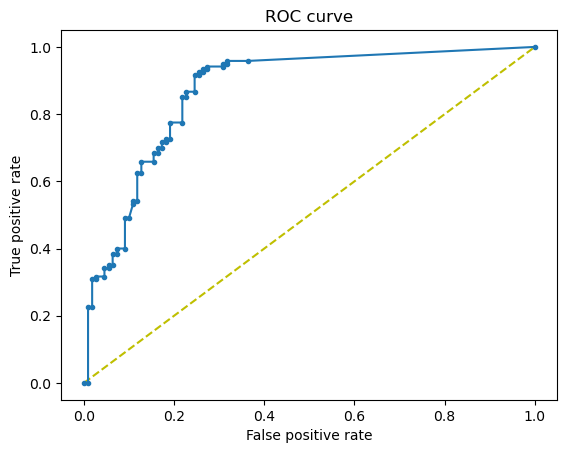

In [17]:
y_preds = model.predict(X_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Area under the curve (AUC)**  for ROC plot can be used to understand how well a classifier is performing. % chance that the model can distinguish between positive and negative classes.
$$
auc_value = auc(fpr, tpr)
$$

In [18]:
# Calculate and display the Area Under the Curve (AUC)
auc_value = auc(fpr, tpr)
print(f"Area Under the Curve (AUC): {auc_value:.2f}")

Area Under the Curve (AUC): 0.87


## Explainability – Feature Contributions (SHAP Values)

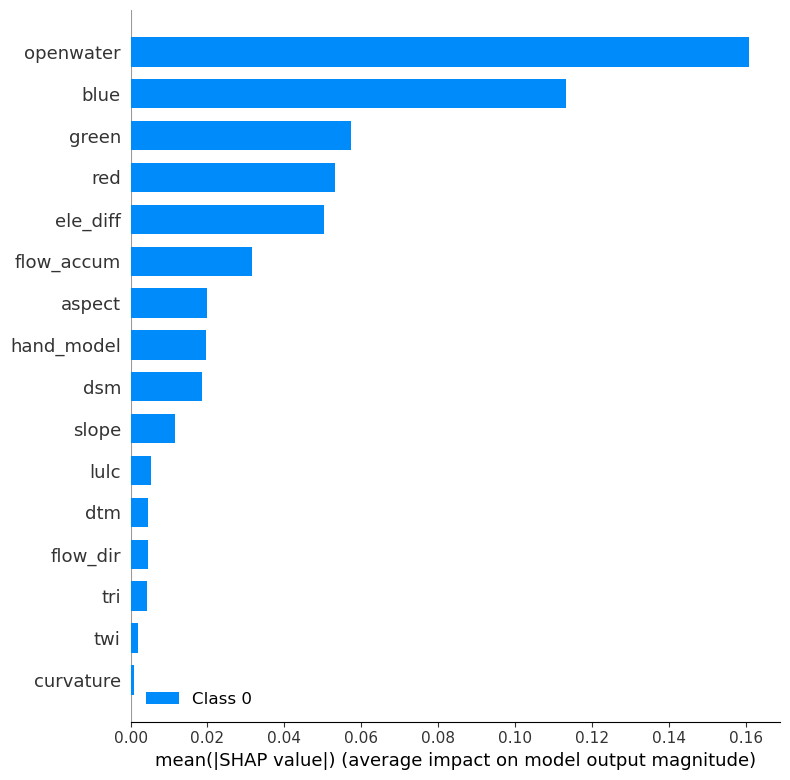

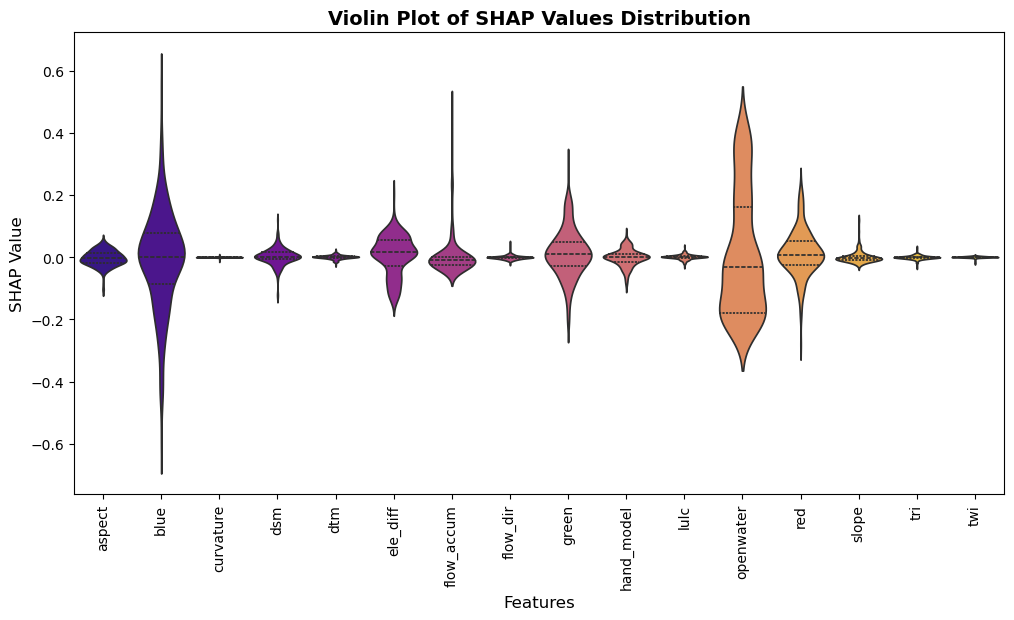

In [19]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset if X_val is too large
background = X_val.sample(100) if len(X_val) > 100 else X_val
background = background.to_numpy()  # Convert to numpy array
X_val_array = X_val.to_numpy()  # Convert to numpy array

# Ensure the feature names are correctly extracted
feature_names = X_val.columns.tolist()

# Initialize DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Get SHAP values
shap_values = explainer.shap_values(X_val_array)

# Summary plot with feature names
shap.summary_plot(shap_values, X_val_array, feature_names=feature_names)

# Force plot for one instance with feature names
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_val_array[0], feature_names=feature_names)

# Violin plot for SHAP values distribution for each feature
shap_values_array = shap_values[0]  # For binary classification or first class in multi-class classification

# Convert SHAP values to DataFrame for easier plotting
shap_df = pd.DataFrame(shap_values_array, columns=feature_names)

# Create a violin plot for SHAP values
plt.figure(figsize=(12, 6))
sns.violinplot(data=shap_df, inner="quart", palette="plasma")
plt.title("Violin Plot of SHAP Values Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Features", fontsize=12)
plt.ylabel("SHAP Value", fontsize=12)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.show()


### Model Performance Overview

8/8 [==============================] - 0s 3ms/step
              Score
Accuracy   0.830435
Precision  0.845471
Recall     0.830435
F1-Score   0.827564
ROC-AUC    0.870417
Log Loss   0.470012


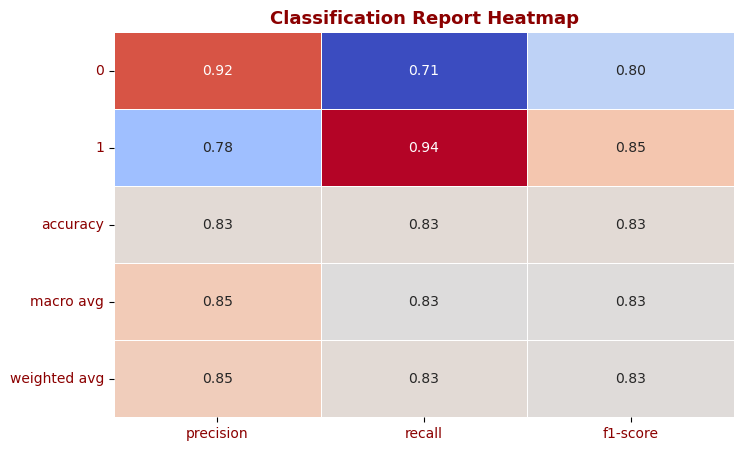

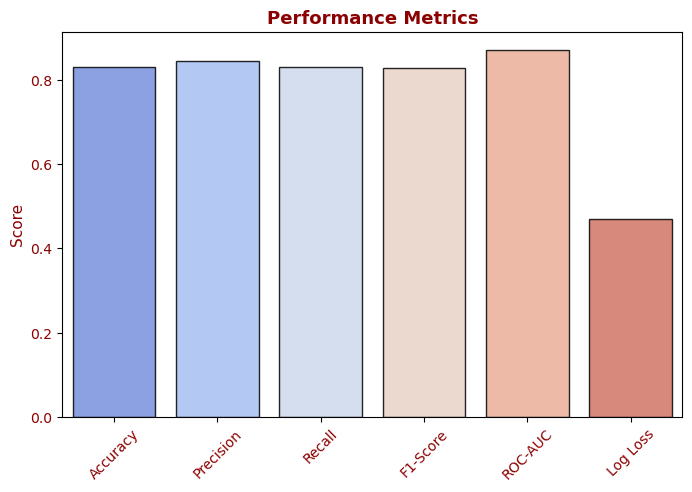

,Score
Accuracy,0.830435
Precision,0.845471
Recall,0.830435
F1-Score,0.827564
ROC-AUC,0.870417
Log Loss,0.470012


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, classification_report


def evaluate_classification(model, X_val, y_val):
    """Evaluates a classification model on the validation set."""

    # Generate predictions
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels

    # Compute metrics
    metrics = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, average="weighted"),
        "Recall": recall_score(y_val, y_pred, average="weighted"),
        "F1-Score": f1_score(y_val, y_pred, average="weighted"),
        "ROC-AUC": roc_auc_score(y_val, y_pred_proba, average="weighted"),
        "Log Loss": log_loss(y_val, y_pred_proba)
    }

    # Convert metrics to DataFrame
    df_metrics = pd.DataFrame(metrics, index=["Score"]).T
    print(df_metrics)

    # --- Heatmap for classification report ---
    class_report = classification_report(y_val, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).iloc[:-1, :].T

    plt.figure(figsize=(8, 5))
    sns.heatmap(class_report_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=False)
    plt.title("Classification Report Heatmap", fontsize=13, fontweight="bold", color="#8B0000")
    plt.xlabel("")
    plt.ylabel("", fontsize=11, color="#8B0000")
    plt.xticks(color="#8B0000")
    plt.yticks(color="#8B0000")
    plt.show()

    # --- Bar plot for metrics ---
    df_metrics_reset = df_metrics.reset_index().rename(columns={"index": "Metric", "Score": "Value"})
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_metrics_reset, x="Metric", y="Value",
                     palette="coolwarm", edgecolor="black", alpha=0.85)

    plt.title("Performance Metrics", fontsize=13, fontweight="bold", color="#8B0000")
    plt.xlabel("")
    plt.ylabel("Score", fontsize=11, color="#8B0000")
    ax.tick_params(axis='x', labelrotation=45)
    plt.xticks(color="#8B0000")
    plt.yticks(color="#8B0000")
    plt.show()

    return df_metrics




evaluate_classification(model, X_val, y_val)

## Create Final Flood Prediction Image

In [21]:
# Load Parquet file and filter out unwanted columns
query = f"""
    SELECT * 
    FROM read_parquet('{FLOOD_PREDICTIVE_PAQ_PATH}')
"""

predictive_points_gdf = duckdb.query(query).to_df()

# Display first few rows
predictive_points_gdf.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,aspect,blue,curvature,dsm,dtm,ele_diff,flow_accum,flow_dir,green,hand_model,lulc,openwater,red,slope,tri,twi,geometry
0,76.119675,74.949997,-0.020323,27.209251,27.292253,-0.000610,205.0,1,100.216667,1.307781,2.0,6407.812988,89.099998,1.439962,5.217555,3.294915,"[1, 1, 0, 0, 0, 48, 237, 13, 254, 57, 228, 17,..."
1,234.869766,77.343750,-0.094849,27.182995,27.211967,-0.003515,207.0,1,101.468750,1.284430,2.0,6409.442383,92.375000,3.859596,5.220508,5.467918,"[1, 1, 0, 0, 0, 64, 237, 13, 254, 65, 228, 17,..."
2,251.640778,77.828125,-0.028900,27.345192,27.325544,-0.005638,209.0,1,101.546875,1.448750,2.0,6411.072266,90.515625,2.795572,5.232246,NaN,"[1, 1, 0, 0, 0, 64, 237, 13, 254, 73, 228, 17,..."
3,348.041534,75.484375,0.252442,27.666517,27.430872,0.002535,211.0,1,100.843750,1.761902,4.0,6412.702637,85.859375,5.388470,5.242649,NaN,"[1, 1, 0, 0, 0, 32, 237, 13, 254, 81, 228, 17,..."
4,358.553162,75.312500,-0.060337,27.399494,27.479311,0.005665,213.0,1,103.687500,1.491749,4.0,6414.333008,87.187500,6.887883,5.238132,5.730828,"[1, 1, 0, 0, 0, 48, 237, 13, 254, 89, 228, 17,..."


In [22]:
drops_columns = ['geometry', ]
predictive_points = predictive_points_gdf.drop(drops_columns, axis=1)
predictive_points.columns

Index(['aspect', 'blue', 'curvature', 'dsm', 'dtm', 'ele_diff', 'flow_accum',
       'flow_dir', 'green', 'hand_model', 'lulc', 'openwater', 'red', 'slope',
       'tri', 'twi'],
      dtype='object')

In [23]:
cols = X_train.columns  # Get the columns names from X_train
X_predict = predictive_points[cols]  # Ensure correct variable name

# Replace all NaN values with 0
X_predict  = X_predict.fillna(0)

# Replace all -9999 values with 0
X_predict  = X_predict.replace(-9999, 0)

In [24]:
# Ensure X_predict is a NumPy array and has the correct data type
X_predict = np.array(X_predict, dtype=np.float32)  # Convert to NumPy array with float32 type

# Get the probability predictions for the positive class (binary classification)
predict_rf_proba = model.predict(X_predict)  # This will return probabilities for binary classification
predictive_points_gdf['dnn'] = predict_rf_proba[:, 0]  # For binary classification, the result is a 2D array with shape (n_samples, 1)

429751/429751 [==============================] - 1071s 2ms/step


In [25]:
# Replace -9999 with 0
predictive_points_gdf = predictive_points_gdf.replace(-9999, 0)

# Export to parquet
predictive_points_gdf.to_parquet(os.path.join(OUTPUT_DIR, "predictive_points_dl.parquet"), index=False)

In [26]:
# features_list = list(X.columns) 

# IMAGE-BASED PREDICTION USING DEEP LEARNING (CNN)

Read the Data and Prepare it for the model

In [27]:
# Read the preditive features and the label (Notflooded=0, flooded=1)
# Create an output directory if it doesn't exist
INDIVIDUAL_FEATURES = os.path.join(DATA_DIR, "individual_features")

CATEGORIES= ["NotFlooded", "Flooded"]

In [28]:
INDIVIDUAL_FEATURES

'C:/Users/Admin/Desktop/geoai_flood_prediction\\data/PH_METRO/TRAIN\\individual_features'

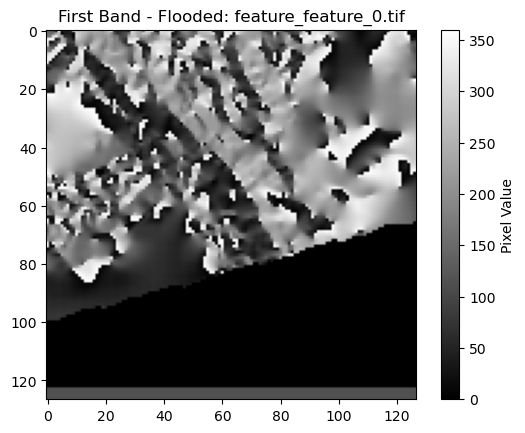

In [29]:
# Define your categories and data path
CATEGORIES = ["Flooded", "NotFlooded"]

for category in CATEGORIES:
    path = os.path.join(INDIVIDUAL_FEATURES, category)  # Path to Flooded/NotFlooded dirs

    if not os.path.exists(path) or not os.listdir(path):  
        print(f"Warning: No images found in {path}")
        continue  # Skip if the directory is empty

    for img in os.listdir(path):
        img_path = os.path.join(path, img)

        # Open image safely using 'with' to ensure it's closed properly
        with rasterio.open(img_path) as img_open:
            img_array = img_open.read(1)  # Read the first band

        # Replace negative values with NaN
        img_array = np.where(img_array < 0, np.nan, img_array)

        # Compute the mean while ignoring NaNs
        mean_value = np.nanmean(img_array) if not np.isnan(img_array).all() else 0

        # Replace NaN values with the mean
        img_array = np.where(np.isnan(img_array), mean_value, img_array)

        # Plot the image
        plt.imshow(img_array, cmap="gray")
        plt.colorbar(label="Pixel Value")  # Add a color scale
        plt.title(f"First Band - {category}: {img}")
        plt.show()

        break  # Only process the first image per category
    break  # Only process the first category

In [30]:
# List all .tif files in the input directory
tif_files = [file for file in os.listdir(INPUT_DIR) if file.endswith(".tif")]
tif_files

['aspect.tif',
 'blue.tif',
 'composite_raster.tif',
 'curvature.tif',
 'dsm.tif',
 'dtm.tif',
 'ele_diff.tif',
 'flow_accum.tif',
 'flow_dir.tif',
 'green.tif',
 'hand_model.tif',
 'lulc.tif',
 'openwater.tif',
 'red.tif',
 'slope.tif',
 'tri.tif',
 'twi.tif']

In [31]:
tif_files = [file for file in tif_files if file !='composite_raster.tif']
tif_files

['aspect.tif',
 'blue.tif',
 'curvature.tif',
 'dsm.tif',
 'dtm.tif',
 'ele_diff.tif',
 'flow_accum.tif',
 'flow_dir.tif',
 'green.tif',
 'hand_model.tif',
 'lulc.tif',
 'openwater.tif',
 'red.tif',
 'slope.tif',
 'tri.tif',
 'twi.tif']

In [32]:
len(tif_files)

16

In [33]:
# Define empty lists for each variable
aspect = []
blue = []
# classified_rf = []
curvature = []
# dis_tarred_road = []
# dis_unpaved_road = []
dsm = []
dtm = []
ele_diff = []
flow_accumulation = []
flow_direction = []
green = []
hand_model = []
lulc = []
dis_open_water = []
red = []
slope = []
tri = []
twi = []
# Ensure the output list is initialized
y = []

# List to store predictive features
predictive_features = [
    aspect, blue, curvature,dsm, dtm,ele_diff , flow_accumulation, flow_direction, green, 
    hand_model, lulc, dis_open_water, red, slope, tri, twi
]

print(len(predictive_features)) 

16


In [34]:
%%capture
def create_training_data():
    """Extracts raster features from images and organizes them into predictive_features."""
    for i in range(len(predictive_features)):
        print(f"Processing Band {i+1}/{len(predictive_features)}")
        
        for category in CATEGORIES:
            path = os.path.join(INDIVIDUAL_FEATURES, category)  # Path to Flooded and NotFlooded directories
            class_num = CATEGORIES.index(category)

            for img in os.listdir(path):
                try:
                    img_path = os.path.join(path, img)
                    with rasterio.open(img_path) as img_open:
                        print(f"Processing: {category}/{img} - Class {class_num}")

                        img_array = img_open.read(i + 1)  # Read the corresponding band

                        # Handle negative values by replacing with NaN
                        img_array = np.where(img_array < 0, np.nan, img_array)
                        
                        # Replace NaNs with the mean of the array
                        mean_value = np.nanmean(img_array)
                        img_array = np.where(np.isnan(img_array), mean_value, img_array)

                        # Store in the corresponding predictive feature list
                        predictive_features[i].append(img_array)

                        # Store the class label (only once per image)
                        if i == 0:
                            y.append(class_num)
                
                except Exception as e:
                    print(f"Error processing {img}: {e}")

create_training_data()

In [35]:
np.shape(dtm[0]) # check image size

(127, 127)

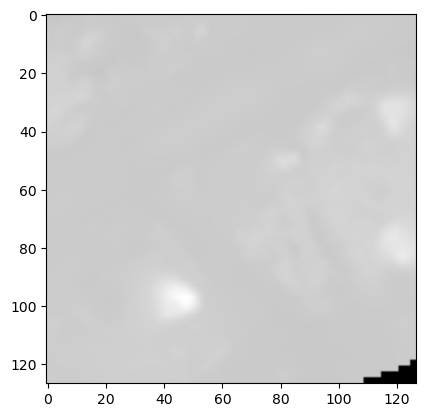

In [36]:
# plot the first image to check that the function is working
plt.imshow(dtm[1],cmap="gray")
plt.show()

In [37]:
# check the number of images 
len(dtm)

1150

In [38]:
%%capture
for i, img in enumerate(aspect):
    print(f"aspect[{i}] shape:", np.array(img).shape)

### Resize All Images Before Conversion

In [39]:
import cv2
import numpy as np

IMG_SIZE = 128  # Define the target size

# Function to resize images in a list
def resize_images(image_list):
    return [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in image_list]

# Resize all feature lists
aspect = resize_images(aspect)
blue = resize_images(blue)
curvature = resize_images(curvature)
# dis_tarred_road = resize_images(dis_tarred_road)
# dis_unpaved_road = resize_images(dis_unpaved_road)
dsm = resize_images(dsm)
dtm = resize_images(dtm)
ele_diff = resize_images(ele_diff)
flow_accumulation = resize_images(flow_accumulation)
flow_direction = resize_images(flow_direction)
green = resize_images(green)
hand_model = resize_images(hand_model)
dis_open_water = resize_images(dis_open_water)
lulc = resize_images(lulc)
red = resize_images(red)
slope = resize_images(slope)
tri = resize_images(tri)
twi = resize_images(twi)

### Convert to NumPy Arrays

In [40]:
aspect_array = np.array(aspect).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
blue_array = np.array(blue).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# classified_rf_array = np.array(classified_rf).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
curvature_array = np.array(curvature).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# dis_tarred_road_array = np.array(dis_tarred_road).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# dis_unpaved_road_array = np.array(dis_unpaved_road).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
dsm_array = np.array(dsm).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
dtm_array = np.array(dtm).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
elev_diff_array = np.array(ele_diff).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
flow_accumulation_array = np.array(flow_accumulation).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
flow_direction_array = np.array(flow_direction).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
green_array = np.array(green).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
hand_model_array = np.array(hand_model).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
dis_open_water_array = np.array(dis_open_water).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
lulc_array =  np.array(lulc).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
red_array = np.array(red).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
slope_array = np.array(slope).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
tri_array = np.array(tri).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
twi_array = np.array(twi).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [41]:
aspect_array.shape
# number of images x image size x image size x number of bands

(1150, 128, 128, 1)

In [42]:
# concatenation all the features into a single array
X_array = np.concatenate([
    aspect_array, blue_array, curvature_array, 
    dsm_array, dtm_array, elev_diff_array, flow_accumulation_array, flow_direction_array, 
    green_array, hand_model_array, dis_open_water_array, lulc_array, red_array, slope_array, 
    tri_array, twi_array
], axis=-1)

# Expected shape: (num_samples, 127, 127, num_features)
print("Final X_array shape:", X_array.shape)  

Final X_array shape: (1150, 128, 128, 16)


## Split Data for Modelling

In [43]:
# split the data into training (80%), validation (20%)
X_train,X_val,y_train,y_val = train_test_split(X_array,y,test_size=0.2,random_state=42)

## Model

In [55]:
def check_and_handle_nan_values(data, name="Data"):
    """Handle NaN values more robustly with detailed reporting."""
    total_elements = np.prod(data.shape)
    nan_count = np.isnan(data).sum()
    nan_percentage = (nan_count / total_elements) * 100
    
    print(f"Checking {name} for NaN values...")
    print(f"Number of NaNs in {name}: {nan_count} ({nan_percentage:.2f}% of all elements)")
    
    if nan_count > 0:
        for i in range(data.shape[-1]):
            band = data[:, :, :, i]
            nan_mask = np.isnan(band)
            nan_band_count = np.sum(nan_mask)
            
            if nan_band_count > 0:
                band_mean = np.nanmean(band)
                if np.isnan(band_mean):  # Entire band is NaN
                    print(f"WARNING: Band {i} contains only NaNs! Filling with zeros.")
                    band[nan_mask] = 0.0
                else:
                    band[nan_mask] = band_mean
                    print(f"  - Band {i}: Replaced {nan_band_count} NaNs with mean value {band_mean:.6f}")
    
    # Final check and replacement of any remaining NaNs with zeros
    if np.isnan(data).any():
        remaining_nans = np.isnan(data).sum()
        print(f"WARNING: {remaining_nans} NaNs still remain in {name}. Replacing with zeros.")
        data = np.nan_to_num(data, nan=0.0)
    
    return data

In [56]:
def robust_normalize_data(data, name="Data", clip_percentile=99.5):
    """Normalize 4D data with robust z-score scaling and optional outlier clipping."""
    print(f"Normalizing {name} with robust method...")

    for i in range(data.shape[-1]):
        band = data[:, :, :, i]
        valid_values = band[~np.isnan(band)]

        if valid_values.size == 0:
            print(f"  - WARNING: Band {i} has no valid values. Skipping.")
            continue

        # Basic statistics
        min_val, max_val = np.min(valid_values), np.max(valid_values)
        mean_val, std_val = np.mean(valid_values), np.std(valid_values)
        print(f"  - Band {i} stats: min={min_val:.4f}, max={max_val:.4f}, mean={mean_val:.4f}, std={std_val:.4f}")

        # Clip extreme values (robust outlier removal)
        if clip_percentile < 100:
            clip_val = np.percentile(valid_values, clip_percentile)
            extreme_mask = band > clip_val
            print(f"  - Clipping {np.sum(extreme_mask)} values above {clip_val:.4f}")
            band = np.where(extreme_mask, clip_val, band)

        # Normalize using z-score or fallback
        if std_val > 0:
            band = (band - mean_val) / std_val
        else:
            print(f"  - WARNING: Band {i} has near-constant values. Using min-max scaling.")
            range_val = max_val - min_val
            if range_val > 0:
                band = (band - min_val) / range_val
            else:
                print(f"  - WARNING: Band {i} values are constant. Filling with zeros.")
                band = np.zeros_like(band)

        data[:, :, :, i] = band

    # Clean up any NaNs or infs
    if np.isnan(data).any():
        print(f"  - WARNING: Found NaNs. Replacing with zeros.")
        data = np.nan_to_num(data, nan=0.0)
    if np.isinf(data).any():
        print(f"  - WARNING: Found inf values. Replacing with zeros.")
        data = np.nan_to_num(data, posinf=0.0, neginf=0.0)

    return data


In [57]:
x_train = np.array(X_train).astype("float32")
X_val = np.array(X_val).astype("float32")
y_train = np.array(y_train).astype("float32")
y_val = np.array(y_val).astype("float32")

# Step 2: Check for NaN values before processing
x_train = check_and_handle_nan_values(x_train, "x_train")
x_val = check_and_handle_nan_values(X_val, "X_val")



# Step 4: Check for NaN values before processing
x_train = robust_normalize_data(x_train, "x_train")
x_val = robust_normalize_data(X_val, "X_val")

Checking x_train for NaN values...
Number of NaNs in x_train: 2445964 (1.01% of all elements)
  - Band 2: Replaced 1373129 NaNs with mean value inf
  - Band 5: Replaced 660677 NaNs with mean value inf
  - Band 10: Replaced 2558 NaNs with mean value inf
  - Band 11: Replaced 409600 NaNs with mean value 2.959538
Checking X_val for NaN values...
Number of NaNs in X_val: 0 (0.00% of all elements)
Normalizing x_train with robust method...
  - Band 0 stats: min=0.0000, max=359.9945, mean=171.3279, std=98.2633
  - Clipping 75366 values above 352.1833
  - Band 1 stats: min=0.0000, max=254.9664, mean=94.9653, std=50.0592
  - Clipping 75366 values above 211.1369
  - Band 2 stats: min=0.0000, max=inf, mean=inf, std=nan
  - Clipping 0 values above nan
  - WARNING: Band 2 has near-constant values. Using min-max scaling.
  - Band 3 stats: min=0.0000, max=72.8247, mean=29.4741, std=12.2293
  - Clipping 75367 values above 54.5202
  - Band 4 stats: min=0.0000, max=54.0184, mean=27.9536, std=11.4755
  -

In [80]:
# === Step 5: Enhanced CNN Model with BatchNorm ===
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, UpSampling2D

def build_flood_map_model(input_shape=(128, 128, 16)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)

    # Decoder
    x = UpSampling2D()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Output flood mask (same height and width as input)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    return Model(inputs, outputs)


import os
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === STEP 1: Create Model ===
model = build_flood_map_model(input_shape=x_train.shape[1:])
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === STEP 2: Setup Log Directory ===
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

# === STEP 3: Define Callbacks ===
callbacks = [
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=log_dir)
]

# === STEP 4: Mild Data Augmentation ===
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# === STEP 5: Train Model ===
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=5),
    validation_data=(x_val, y_val),
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 16)]    0         
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_33 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_34 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 32)        0   

ValueError: in user code:

    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, None, None, 1) vs (None, None)).


In [86]:
# === Enhanced Flood Map Prediction Model with U-Net Architecture ===
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
import os
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_flood_map_model(input_shape=(128, 128, 16)):
    inputs = Input(shape=input_shape)
    
    # ========== Encoder Pathway ==========
    # Block 1 (Original resolution: 128x128)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x1 = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample to 64x64
    x1 = Dropout(0.2)(x1)
    
    # Block 2 (64x64 resolution)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x1)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample to 32x32
    x2 = Dropout(0.2)(x2)
    
    # ========== Decoder Pathway with Skip Connections ==========
    # Up Block 1 (32x32 -> 64x64)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x2)
    x = BatchNormalization()(x)
    x = concatenate([x, x1])  # Skip connection from Block 1
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Up Block 2 (64x64 -> 128x128)
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Final Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    return Model(inputs, outputs)

# === Training Configuration ===
def train_model(x_train, y_train, x_val, y_val):
    # Model initialization
    model = build_flood_map_model(x_train.shape[1:])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Callbacks
    callbacks = [
        ModelCheckpoint("unet_flood_model.h5", monitor='val_loss', 
                        save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, 
                     restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=1e-6, verbose=1),
        TensorBoard(log_dir=os.path.join("logs", 
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
    ]
    
    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='reflect'
    )
    
    # Model Training
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        steps_per_epoch=len(x_train)//32,
        validation_data=(x_val, y_val),
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [87]:
# Initialize and train model
model, training_history = train_model(x_train, y_train, x_val, y_val)

# For predictions
flood_mask = model.predict(test_data)  # Returns values 0-1

Epoch 1/50


ValueError: in user code:

    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Admin\AppData\Local\ESRI\conda\envs\myarcgispro\Lib\site-packages\keras\src\backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, None, None, 1) vs (None, None)).


# Visualise Model

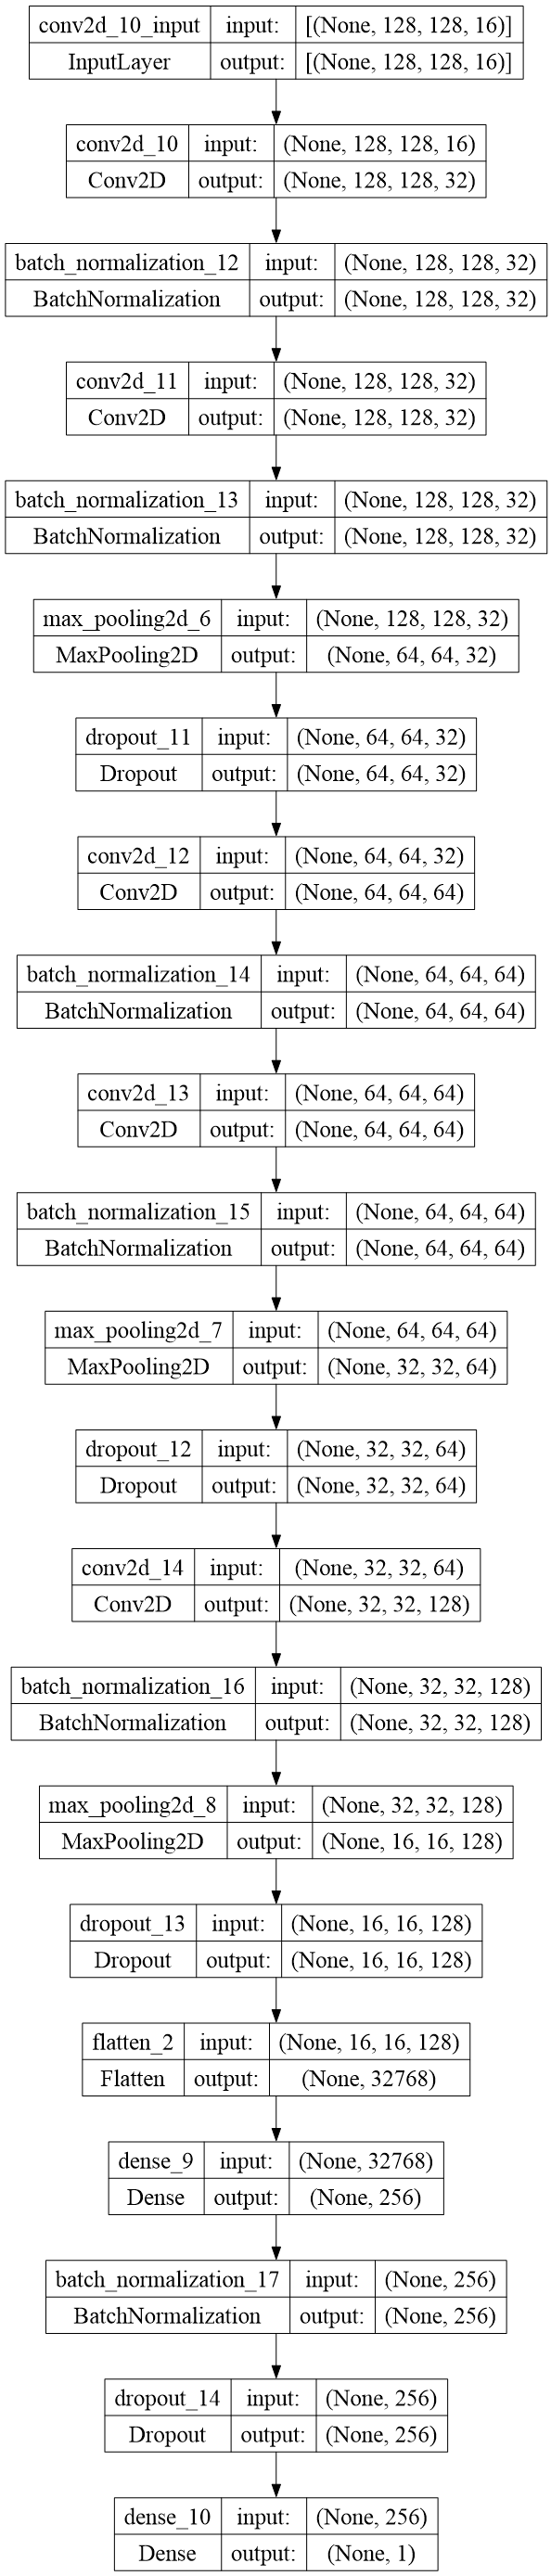

In [74]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

## Model Perfomances

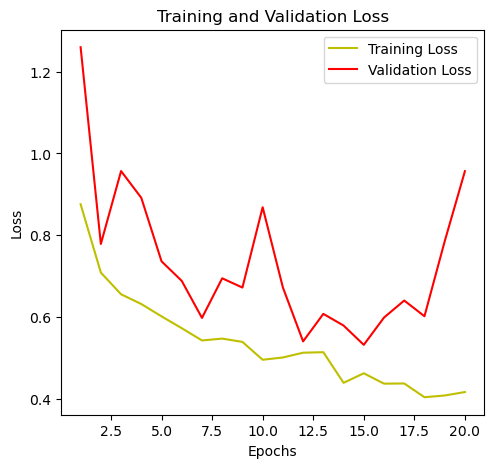

In [60]:
# Extract loss and accuracy values
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

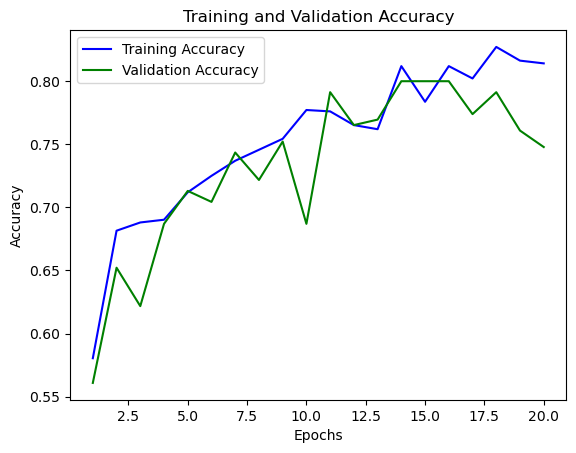

In [69]:
# Plot training & validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [62]:
# Ensure x_val and y_val are NumPy arrays

x_test = np.array(X_val)
y_test = np.array(y_val)

# Evaluate model
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy = {acc * 100:.2f}%")


8/8 [==============================] - 8s 944ms/step - loss: 0.5320 - accuracy: 0.8000
Test Accuracy = 80.00%


### Confusion matrix

8/8 [==============================] - 8s 878ms/step
Confusion Matrix:
 [[112  15]
 [ 31  72]]


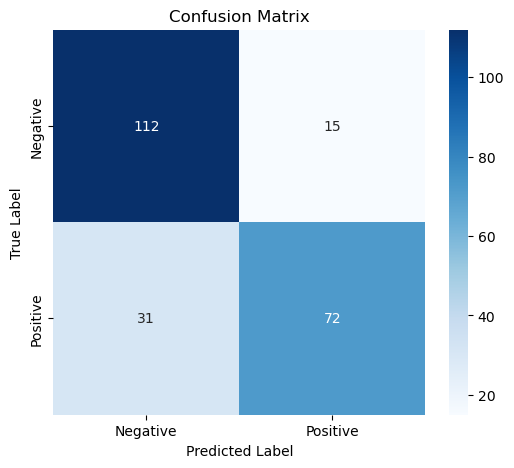

In [63]:
# Define threshold
mythreshold = 0.5

# Get model predictions (probabilities) and convert to binary labels
y_pred = (model.predict(x_test) >= mythreshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print raw confusion matrix
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")

plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [64]:
# classification_report

# Define class labels
target_names = ['Not Flooded', 'Flooded']

# Generate classification report
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

 Not Flooded       0.78      0.88      0.83       127
     Flooded       0.83      0.70      0.76       103

    accuracy                           0.80       230
   macro avg       0.81      0.79      0.79       230
weighted avg       0.80      0.80      0.80       230



In [65]:
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa score
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Cohen's Kappa Score: {kappa:.4f}")

Cohen's Kappa Score: 0.5896


8/8 [==============================] - 7s 904ms/step


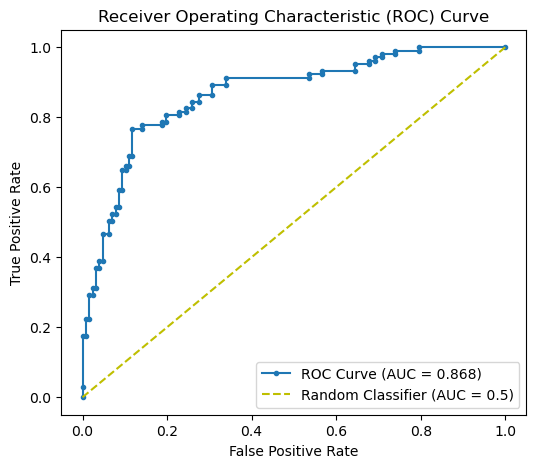

In [66]:
# Get predicted probabilities
y_preds = model.predict(x_test).ravel()  # Flatten to 1D

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'y--', label="Random Classifier (AUC = 0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Find the best threshold (Youden’s J statistic)
j_scores = tpr - fpr  # Youden’s J = Sensitivity - (1 - Specificity)
best_threshold = thresholds

In [67]:
#One way to find the best threshold once we calculate the true positive 
#and false positive rates is ...
#The optimal cut off point would be where “true positive rate” is high 
#and the “false positive rate” is low. 
#Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)

import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn

Ideal threshold is:  36    0.303718
Name: thresholds, dtype: float32


In [68]:
#AUC
#Area under the curve (AUC) for ROC plot can be used to understand how well a classifier is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.8675177738704992


## Explainability – Feature Contributions (SHAP Values)

# Model Performance

8/8 [==============================] - 10s 1s/step
              Score
Accuracy   0.800000
Precision  0.803087
Recall     0.800000
F1-Score   0.797505
ROC-AUC    0.867518
Log Loss   0.532042


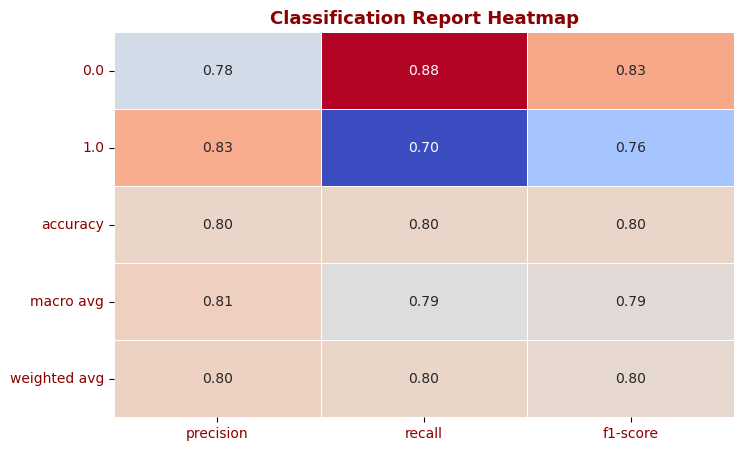

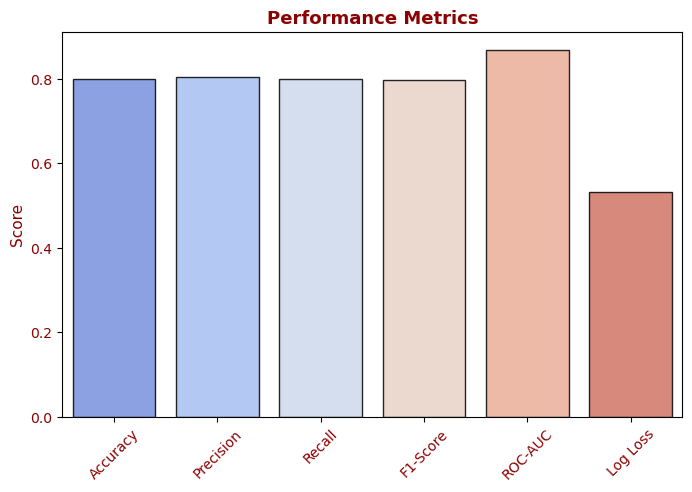

,Score
Accuracy,0.800000
Precision,0.803087
Recall,0.800000
F1-Score,0.797505
ROC-AUC,0.867518
Log Loss,0.532042


In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, classification_report


def evaluate_classification(model, x_val, y_val):
    """Evaluates a classification model on the validation set."""

    # Generate predictions
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels

    # Compute metrics
    metrics = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, average="weighted"),
        "Recall": recall_score(y_val, y_pred, average="weighted"),
        "F1-Score": f1_score(y_val, y_pred, average="weighted"),
        "ROC-AUC": roc_auc_score(y_val, y_pred_proba, average="weighted"),
        "Log Loss": log_loss(y_val, y_pred_proba)
    }

    # Convert metrics to DataFrame
    df_metrics = pd.DataFrame(metrics, index=["Score"]).T
    print(df_metrics)

    # --- Heatmap for classification report ---
    class_report = classification_report(y_val, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).iloc[:-1, :].T

    plt.figure(figsize=(8, 5))
    sns.heatmap(class_report_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=False)
    plt.title("Classification Report Heatmap", fontsize=13, fontweight="bold", color="#8B0000")
    plt.xlabel("")
    plt.ylabel("", fontsize=11, color="#8B0000")
    plt.xticks(color="#8B0000")
    plt.yticks(color="#8B0000")
    plt.show()

    # --- Bar plot for metrics ---
    df_metrics_reset = df_metrics.reset_index().rename(columns={"index": "Metric", "Score": "Value"})
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_metrics_reset, x="Metric", y="Value",
                     palette="coolwarm", edgecolor="black", alpha=0.85)

    plt.title("Performance Metrics", fontsize=13, fontweight="bold", color="#8B0000")
    plt.xlabel("")
    plt.ylabel("Score", fontsize=11, color="#8B0000")
    ax.tick_params(axis='x', labelrotation=45)
    plt.xticks(color="#8B0000")
    plt.yticks(color="#8B0000")
    plt.show()

    return df_metrics




evaluate_classification(model, x_val, y_val)

***References***


* https://www.researchgate.net/publication/373047227_Flood_Susceptibility_Mapping_Using_Machine_Learning_Algorithms_A_Case_Study_in_Huong_Khe_District_Ha_Tinh_Province_Vietnam
* https://www.mdpi.com/2072-4292/16/12/2163
* https://www.mdpi.com/2624-6511/4/3/65

# Prediction 

In [ ]:
import rasterio
import numpy as np
from tensorflow.keras.models import load_model

# === MAIN OUTPUT PATH ===
OUTPUT_PATH = "cnn_predicted_flood_map.tif"


# === Load Composite Raster ===
composite_path = "composite_image.tif"  # Your 16-band raster

with rasterio.open(composite_path) as src:
    composite = src.read().astype(np.float32)  # shape: (16, H, W)
    profile = src.profile
    profile.update(count=1, dtype=rasterio.float32)

# === Prepare Data for CNN Model ===
composite = np.moveaxis(composite, 0, -1)  # → (H, W, 16)
input_array = composite[np.newaxis, ...]   # → (1, H, W, 16)

# Clean NaNs and normalize
input_array = check_and_handle_nan_values(input_array , "X_val")
input_array  = robust_normalize_data(input_array , "x_train")

# === Load Model and Predict ===
model = load_model("best_model.h5") 
prediction = model.predict(input_array) 
flood_map = prediction[0, :, :, 0]

# === Save the Predicted Flood Map ===
with rasterio.open(OUTPUT_PATH, "w", **profile) as dst:
    dst.write(flood_map.astype(np.float32), 1)

print(f"Flood map saved to: {OUTPUT_PATH}")

In [78]:
from keras.models import load_model
model = load_model('best_model.h5')

In [79]:
model.predict(processed_predicts)